170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 614s 392ms/step - accuracy: 0.4530 - loss: 6.7476
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 601s 385ms/step - accuracy: 0.5991 - loss: 1.7671
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 627s 388ms/step - accuracy: 0.6068 - loss: 1.5337
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 601s 385ms/step - accuracy: 0.6005 - loss: 1.5280
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 600s 384ms/step - accuracy: 0.5941 - loss: 1.5559


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_19
Received: inputs=['Tensor(shape=(5, 32, 32, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_19
Received: inputs=['Tensor(shape=(50, 32, 32, 3))']
  warnings.warn(msg)


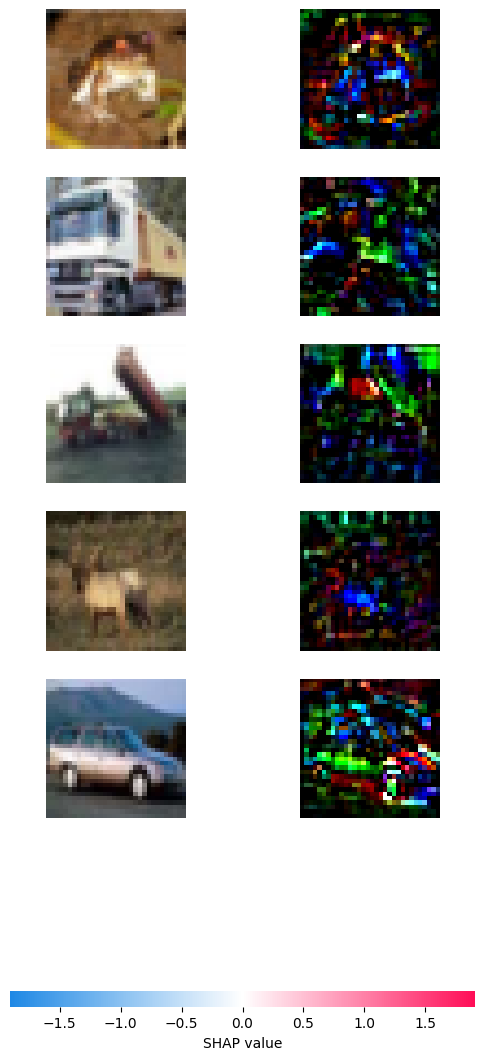

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
import shap
import numpy as np

# Load CIFAR-10 Data
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Convert the images to float type and scale to [0, 1]
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

# Preprocess images in the same way as VGG16 model does
train_images_preprocessed = tf.keras.applications.vgg16.preprocess_input(train_images * 255)  # The preprocess_input function expects images in [0, 255]
test_images_preprocessed = tf.keras.applications.vgg16.preprocess_input(test_images * 255)

# Load Pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(train_images_preprocessed, train_labels, epochs=5)

# Choose the images you want to explain
to_explain = train_images_preprocessed[0:5]

# Create an explainer object
explainer = shap.GradientExplainer(model, train_images_preprocessed[:100])

# Compute SHAP values
shap_values = explainer.shap_values(to_explain)

# Function to reverse the preprocessing function of VGG16 and swap back to 'RGB' order
def reverse_preprocess_input(im):
    mean = [103.939, 116.779, 123.68]
    im[..., 0] += mean[0]
    im[..., 1] += mean[1]
    im[..., 2] += mean[2]
    im = im[..., ::-1]  # reverse axis bgr->rgb
    return im / 255.

# Reverse preprocessing for the SHAP image plot
to_explain_unprocessed = reverse_preprocess_input(to_explain.copy())

# Plot the SHAP values
shap.image_plot(shap_values, to_explain_unprocessed)